# Rate of convergence

#### Homework 3 - Tsatsral Mendsuren, Didier Merk

In this notebook we will demonstrate a Python program, that is able to simulate fictitious play for arbitrary 2x2 zero-sum games. The program will be used to give some insight into how to measure the 'distance' between two consecutive profiles of empirical mixed strategies; in addition to giving some insight into how many iterations are required before the fictitious play converges and its rate of convergence.

In [1]:
# importing the correct packages
import numpy as np
import random
from fractions import Fraction
from matplotlib import pyplot as plt

In [2]:
# function to calculate expected utility
def expected_utility(utl, s_1, s_2):
    # Strategy matrix
    strat_matrix = [[s_1 * s_2, s_1 * (1 - s_2)], [(1 - s_1) * s_2, (1 - s_1) * (1 - s_2)]]
    
    # Expected utility
    exp_utl = np.multiply(strat_matrix, utl).sum()
    
    return exp_utl

# function that returns best pure action for player
def best_action(utl, s, player):
    
    # what is your best action (calculate expected utilities)
    if player == 1:
        utl_1 = expected_utility(utl, 1, s)
        utl_0 = expected_utility(utl, 0, s)
    if player == 2:
        utl_1 = expected_utility(utl, s, 1)
        utl_0 = expected_utility(utl, s, 0)
    
    # return the best action
    if utl_1 >= utl_0:
        return 1
    else:
        return 0

In [3]:
# function to check if we have converged
def is_converged(actions_played, e):
    
    # if we don't have enough data yet it hasn't converged yet
    if len(actions_played['emp_s1']) <= 1:
        return False
    
    # check if converged
    if np.abs(actions_played['emp_s1'][-1] - actions_played['emp_s1'][-2]) < e:
        if np.abs(actions_played['emp_s2'][-1] - actions_played['emp_s2'][-2]) < e:
            return True
    return False

# function that calculates the convergence_rates
def convergence_rates(actions_played):
    # convergence array
    convergence_array = []
    
    error = 0.00000001
    
    for i in range(len(actions_played['emp_s1']) - 2):  
        nom_q = np.log( np.abs( (actions_played['emp_s1'][i+1] - actions_played['emp_s1'][i]) / (actions_played['emp_s1'][i] - actions_played['emp_s1'][i-1] + error) ) )
        den_q = np.log( np.abs( (actions_played['emp_s1'][i] - actions_played['emp_s1'][i-1]) / (actions_played['emp_s1'][i-1] - actions_played['emp_s1'][i-2] + error) ) )
        convergence_array.append(nom_q / (den_q + error))
        
    return convergence_array

In [4]:
# fictitious play until convergence
def fictitious_play(u_1, u_2, actions_played, e):
    while True:
        # Retrieve empirical mixed strategies and add them to dict

        # Player 1
        emp_mix_p1 = sum(actions_played['p1']) / len(actions_played['p1'])
        actions_played['emp_s1'].append(emp_mix_p1)

        # Player 2
        emp_mix_p2 = sum(actions_played['p2']) / len(actions_played['p2'])
        actions_played['emp_s2'].append(emp_mix_p2)

        # Check if converged
        if is_converged(actions_played, e):
            break

        # Play the best available pure response (and add it to dict)

        # Player 1
        actions_played['p1'].append(best_action(u_1, emp_mix_p2, 1))

        # Player 2
        actions_played['p2'].append(best_action(u_2, emp_mix_p1, 2))
        
    return actions_played

In [5]:
# function that generates games
def generate_game(num_actions_p1=2, num_actions_p2=2):
    # generate random utilities player 1
    u_1 = np.array([random.randrange(-25, 25, 1) for i in range(num_actions_p1*num_actions_p2)])
    
    # player 2 utilities are given (zero-sum game, opposite of u_1)
    u_2 = np.array([0 - i for i in u_1])
    
    # reshape them into correct formats
    u_1 = np.matrix(u_1.reshape(num_actions_p1, num_actions_p2))
    u_2 = np.matrix(u_2.reshape(num_actions_p1, num_actions_p2))
    
    # Test case
#     u_1 = np.array([[1, -1], [-1, 1]])
#     u_2 = np.array([[-1, 1], [1, -1]])

    return u_1, u_2;

In [6]:
# Function that generates a list of all pure Nash equilibria
def pure_NEs(u_1, u_2):
    # retrieve the size of the game
    game_size = u_1.shape
    
    # initialize a list to store pure NEs in
    pure_NE_list = []
    
    # loop over all the cells in the two player normal form game
    for row in range(game_size[0]):
        for col in range(game_size[1]):  
            # when both players DONT want to unilaterally switch
            if u_2[row][col] == u_2[row].max() and u_1[row][col] == u_1[:, col].max():
                # append the found NE
                pure_NE_list.append((1 - row, 1 - col)) 
                
    return pure_NE_list

# Function that finds the mixed Nash equilibrium
def mixed_NEs(u_1, u_2): 
    # player 2 (column player) to be indifferent
    num_p = (u_2[1][1] - u_2[1][0]) #numerator (d - c)
    den_p = (u_2[0][0] - u_2[1][0] - u_2[0][1] + u_2[1][1]) #denominator (a - b - c + d)
    
    # player 1 (row player) to be indifferent
    num_q = (u_1[1][1] - u_1[0][1]) # (h - f)
    den_q = (u_1[0][0] - u_1[1][0] - u_1[0][1] + u_1[1][1]) # (e - f - g + h)
    
    # denominator is 0 for player 2 (column player)
    if den_p == 0:
        if u_2[0][0] == u_2[0][1]:
            q = 'q can be any value ∈ [0, 1]' # does not matter what she does
        elif u_2[0][0] > u_2[0][1]:
            q = 1
        else:
            q = 0
            
    # otherwise p is calculated according to formula
    else:
        p = num_p / den_p 
    
    # denominator is 0 for player 1 (row player)
    if den_q == 0:
        if u_1[0][0] == u_1[1][0]:
            
            p = 'p can be any value ∈ [0, 1]' # does not matter what she does
        elif u_1[0][0] > u_1[1][0]:
            p = 1
        else:
            p = 0
            
    # otherwise q is calculated according to formula
    else:
        q = num_q / den_q
        
    # p and q can not be lower than 0 or higher than 1
    if type(p) is int:
        if type(q) is int:
            if p < 0 or p > 1 or q < 0 or q > 1:
                return None
        else:
            if p < 0 or p > 1:
                return None
    else:
        if q < 0 or q > 1:
            return None
    
    # check if the p and q found are not pure NE
    if 'p' in locals() and 'q' in locals():
        if (p == 0 or p == 1) and (q == 0 or q == 1):
            return None # this means it is a pure NE
        else:
            return p, q # NOT a pure NE
        
    # This means one player had a strictly dominant strategy, meaning no mixed-strategies
    else:
        return None

In [7]:
# function that generates and plays fictitious zero-sum game
def play_game(e):
    # initialize a dict with actions played
    actions_played = {} 
    
    # it is a two player game
    num_players = 2
    
    # initialize a first action for all players (all H for example)
    for i in range(num_players):
        actions_played[f"p{i+1}"] = [random.randint(0,1)]
        actions_played[f"emp_s{i+1}"] = []
        
    # generate the utilities for both players until game without pure NE
    while True:
        u_1, u_2 = generate_game()

        if len(pure_NEs(np.array(u_1), np.array(u_2))) == 0:
            break
        
    # define a convergence treshold
    e = e
    
    # get the real pure and or mixed NEs
    pure_nash = pure_NEs(np.array(u_1), np.array(u_2))
    mixed_nash = mixed_NEs(np.array(u_1), np.array(u_2))
    
    # execute the fictitious play
    actions_played = fictitious_play(u_1, u_2, actions_played, e)
    
    return actions_played, pure_nash, mixed_nash

In [8]:
# function to plot the convergence of games
def plot_convergence(num_games, convergence_fraction):
    # initialize distance lists for both players
    distance_to_mixed_p1 = []
    distance_to_mixed_p2 = []
    
    # lists containing the final distances from convergence to actual mixed nash equilibrium
    fd_p1 = []
    fd_p2 = []
    
    # number of iterations it took to converge for all games
    num_iters = []

    for i in range(num_games):
        # play a randomly generated game
        actions_played, pure_nash, mixed_nash = play_game(convergence_fraction)

        # distance to mixed equilibrium for player 1
        distances_p1 = actions_played['emp_s1'] - mixed_nash[0]
        distance_to_mixed_p1.append(distances_p1)

        # distance to mixed equilibrium for player 2
        distances_p2 = actions_played['emp_s2'] - mixed_nash[1]
        distance_to_mixed_p2.append(distances_p2)
        
        # distances to mixed equilibrium when convergence was reached
        fd_p1.append(distances_p1[-1])
        fd_p2.append(distances_p2[-1])
        
        # number of iterations to reach convergence
        num_iters.append(len(actions_played['emp_s1'])-1)
        
    fig, ax = plt.subplots(figsize=(9, 6))

    for distance in range(len(distance_to_mixed_p1)):
        # list of player 1's distances to mixed equilibrium
        y1 = distance_to_mixed_p1[distance]

        # list of player 2's distances to mixed equilibrium
        y2 = distance_to_mixed_p2[distance]

        # number of timesteps
        x = np.linspace(0, len(y1)-1, len(y1))

        # plotting player 1
        ax.plot(x, y1, label='Player 1')

        # plotting player 2
        ax.plot(x, y2, label='Player 2')

    # Title for the plot
#     ax.set_title(f'Convergence margin = {convergence_fraction}', fontsize=25)
    
    # Delete the spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # labels
    ax.set_xlabel('Number of iterations', fontsize=18)
    ax.set_ylabel('Distance to real mixed NE', fontsize=18)
    
    plt.show()
    
    return fd_p1, fd_p2, num_iters

# Function to calculate fraction of converged games
def fraction_converged(num_iters):
    percentages = []

    for i in range(max(num_iters) + 1):
        amount_lower = sum([1 for n in num_iters if n <= i])
        percentage = amount_lower / len(num_iters) * 100
        percentages.append(percentage) 
        
    return percentages

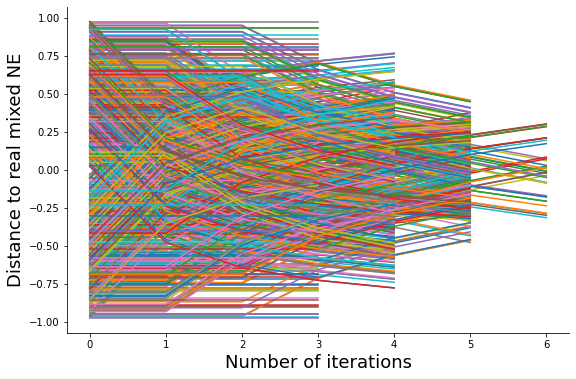

Out of 1000 players, 60 players have converged to within 0.02 of the mixed Nash equilibrium


In [9]:
# Num_games = 500, margin of convergence = 0.1
fd_p1, fd_p2, num_iters = plot_convergence(500, 0.1)

# How many have converged 'closely' to actual mixed Nash equilibrium
close = 0.02
amount_close = sum([1 for n in fd_p1 if np.abs(n) < close]) + sum([1 for n in fd_p2 if np.abs(n) < close])
print(f"Out of {len(fd_p1)*2} players, {amount_close} players have converged to within {close} of the mixed Nash equilibrium")

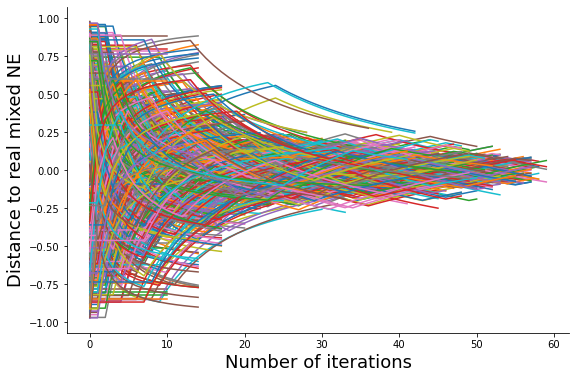

Out of 1000 players, 141 players have converged to within 0.02 of the mixed Nash equilibrium


In [10]:
# Num_games = 500, margin of convergence = 0.01
fd_p1, fd_p2, num_iters = plot_convergence(500, 0.01)

# How many have converged 'closely' to actual mixed Nash equilibrium
close = 0.02
amount_close = sum([1 for n in fd_p1 if np.abs(n) < close]) + sum([1 for n in fd_p2 if np.abs(n) < close])
print(f"Out of {len(fd_p1)*2} players, {amount_close} players have converged to within {close} of the mixed Nash equilibrium")

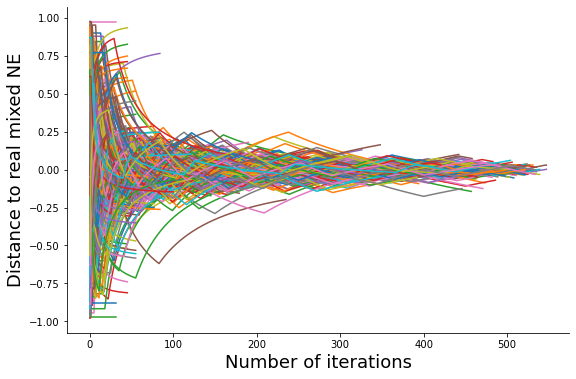

Out of 1000 players, 427 players have converged to within 0.02 of the mixed Nash equilibrium


In [11]:
# Num_games = 500, margin of convergence = 0.001
fd_p1, fd_p2, num_iters = plot_convergence(500, 0.001)

# How many have converged 'closely' to actual mixed Nash equilibrium
close = 0.02
amount_close = sum([1 for n in fd_p1 if np.abs(n) < close]) + sum([1 for n in fd_p2 if np.abs(n) < close])
print(f"Out of {len(fd_p1)*2} players, {amount_close} players have converged to within {close} of the mixed Nash equilibrium")

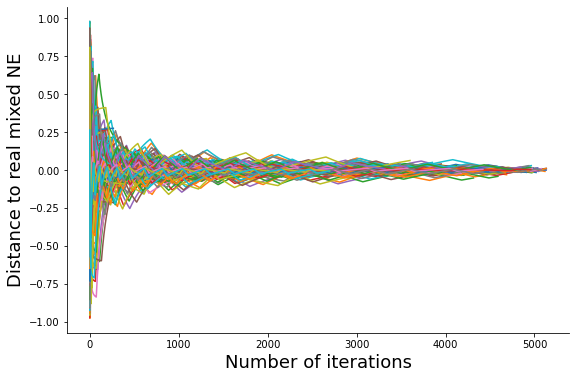

Out of 1000 players, 910 players have converged to within 0.02 of the mixed Nash equilibrium


In [15]:
# Num_games = 500, margin of convergence = 0.0001
fd_p1, fd_p2, num_iters = plot_convergence(500, 0.0001);

# How many have converged 'closely' to actual mixed Nash equilibrium
close = 0.02
amount_close = sum([1 for n in fd_p1 if np.abs(n) < close]) + sum([1 for n in fd_p2 if np.abs(n) < close])
print(f"Out of {len(fd_p1)*2} players, {amount_close} players have converged to within {close} of the mixed Nash equilibrium")

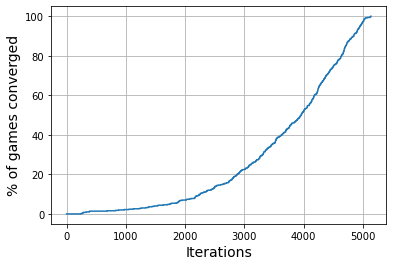

In [17]:
# Time to converged plot
y = fraction_converged(num_iters)
x = np.linspace(0, max(num_iters), max(num_iters) + 1)

# plt.title("Time until convergence", fontsize=18)
plt.xlabel("Iterations", fontsize=14)
plt.ylabel("% of games converged", fontsize=14)

plt.plot(x, y)
plt.grid()
plt.show;